# Example 3: -  Including systematics

## Preparations

Let us first load all the python libraries again

In [3]:
import sys
import os
madminer_src_path = "/Users/dpappadopulo/Projects/~Physics/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

from sklearn.metrics import mean_squared_error

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [4]:
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

To not forget anything later, let us globaly define the number of events in the MG sample

In [5]:
inputfile = 'data/madminer_lhedata_signal.h5'
nsamples = 800000

## 4. Data Augmentation and Machine Learning

### 4a) Make (unweighted) training and test samples with augmented data

Let us make event samples using the `SampleAugmenter`.  For simplicity we use the local data and later train Sally. 

In [4]:
#Define n_estimator
n_estimators = 5

#Initialize
sa  = SampleAugmenter(inputfile)

#augment train sample
for i in range(n_estimators):
    _ , _ , _ = sa.extract_samples_train_local(
        theta=constant_benchmark_theta('sm'), n_samples=int(nsamples/2),
        folder='./data/samples_ensemble/', filename='train{}'.format(i),
        nuisance_score=True
    )
    
#augment test sample
_ , _ , _ = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'), n_samples=int(nsamples/2),
    folder='./data/samples_ensemble/', filename='test', 
    switch_train_test_events=True,
    nuisance_score=True
)

#augment test sample
#_ , _ = sa.extract_samples_test(
#    theta=constant_benchmark_theta('sm'), n_samples=int(nsamples/2),
#    folder='./data/samples_ensemble/', filename='test'
#)

22:22 madminer.sampling    INFO    Loading data from data/madminer_lhedata_signal.h5
22:22 madminer.sampling    INFO    Found 2 parameters
22:22 madminer.sampling    INFO    Found 33 nuisance parameters
22:22 madminer.sampling    INFO    Found 81 benchmarks, of which 6 physical
22:22 madminer.sampling    INFO    Found 14 observables
22:22 madminer.sampling    INFO    Found 84546 events
22:22 madminer.sampling    INFO    Found morphing setup with 6 components
22:22 madminer.sampling    INFO    Found nuisance morphing setup
22:22 madminer.sampling    INFO    Extracting training sample for local score regression. Sampling and score evaluation according to (u'benchmark', u'sm')
/Users/felixkling/Documents/GitHub/madminer/madminer/morphing.py:695: RuntimeWarning: invalid value encountered in log
  a.append(np.log(benchmark_weights[:, i_pos] / benchmark_weights[:, self.i_benchmark_ref]))
22:22 madminer.sampling    INFO    Effective number of samples: 42272.99999998249
22:22 madminer.sampling

### 4b)  Train a neural network to estimate the score

We can now set up an EnsembleForge and train it.

In [5]:
ensemble = EnsembleForge(estimators=n_estimators)
ensemble.train_all(
    method='sally',
    x_filename=['data/samples_ensemble/x_train{}.npy'.format(i) for i in range(n_estimators)],
    t_xz0_filename=['data/samples_ensemble/t_xz_train{}.npy'.format(i) for i in range(n_estimators)]
)
ensemble.save('models/samples_ensemble')

22:22 madminer.ml          INFO    Training 5 estimators in ensemble
22:22 madminer.ml          INFO    Training estimator 1 / 5 in ensemble
22:22 madminer.ml          INFO    Starting training
22:22 madminer.ml          INFO      Method:                 sally
22:22 madminer.ml          INFO      Training data:          x at data/samples_ensemble/x_train0.npy
22:22 madminer.ml          INFO                              t_xz (theta0) at data/samples_ensemble/t_xz_train0.npy
22:22 madminer.ml          INFO      Features:               all
22:22 madminer.ml          INFO      Method:                 sally
22:22 madminer.ml          INFO      Hidden layers:          (100, 100)
22:22 madminer.ml          INFO      Activation function:    tanh
22:22 madminer.ml          INFO      Batch size:             128
22:22 madminer.ml          INFO      Trainer:                amsgrad
22:22 madminer.ml          INFO      Epochs:                 50
22:22 madminer.ml          INFO      Learning rate:   

## 5. Data Analysis

### 5a) Setup Fisher Information

Let us first set up the Fisher Information class

In [6]:
fisher = FisherInformation(inputfile)

00:03 madminer.fisherinfor INFO    Loading data from data/madminer_lhedata_signal.h5
00:03 madminer.fisherinfor INFO    Found 2 parameters
00:03 madminer.fisherinfor INFO    Found 31 nuisance parameters
00:03 madminer.fisherinfor INFO    Found 81 benchmarks, of which 6 physical
00:03 madminer.fisherinfor INFO    Found 3 observables: mll, pt_mu, eta_mu
00:03 madminer.fisherinfor INFO    Found 900000 events
00:03 madminer.fisherinfor INFO    Found morphing setup with 6 components
00:03 madminer.fisherinfor INFO    Found nuisance morphing setup


### 5b) Evaluate Fisher Information - Full, Rate and Histograms

Let us first look at the Fisher Information in the full data, in the rate only and in a few kinematic distributions

In [7]:
"""
fi_full_mean, fi_full_cov = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.], luminosity=300*1000.,
    model_file='models/samples_ensemble',
    unweighted_x_sample_file='data/samples_ensemble/x_test.npy',
)

fi_rate_mean, fi_rate_cov = fisher.calculate_fisher_information_rate(
    theta=[0.,0.],luminosity=300*1000.
)

fi_dphi_mean, fi_dphi_cov = fisher.calculate_fisher_information_hist1d(
    theta=[0.,0.], luminosity=300*1000.,
    observable='dphi_mumu',nbins=20,histrange=(-3.2,3.2)
)
"""
fi_mll_mean, fi_mll_cov = fisher.calculate_fisher_information_hist1d(
    theta=[0.,0.], luminosity=300*1000.,
    observable='mll',nbins=20,histrange=(-3.2,3.2)
)

/Users/dpappadopulo/miniconda3/envs/dpenv27/lib/python2.7/site-packages/madminer/fisherinformation.py:1351: RuntimeWarning: divide by zero encountered in true_divide
  inv_sigma = sanitize_array(1.0 / sigma)  # Shape (n_events,)
/Users/dpappadopulo/miniconda3/envs/dpenv27/lib/python2.7/site-packages/madminer/morphing.py:695: RuntimeWarning: invalid value encountered in true_divide
  a.append(np.log(benchmark_weights[:, i_pos] / benchmark_weights[:, self.i_benchmark_ref]))


### 5c) No Systematics

To again obtain the Fisher Information without systematics, we can use `project_information()` to project out the nuisance parameter (set them all to zero).

In [11]:
"""
fi_full_mean_proj, fi_full_cov_proj = project_information(
    fisher_information=fi_full_mean, covariance=fi_full_cov,remaining_components=[0,1])
fi_rate_mean_proj, fi_rate_cov_proj = project_information(
    fisher_information=fi_rate_mean, covariance=fi_rate_cov,remaining_components=[0,1])
fi_dphi_mean_proj, fi_dphi_cov_proj = project_information(
    fisher_information=fi_dphi_mean, covariance=fi_dphi_cov,remaining_components=[0,1])
"""
fi_mll_mean_proj, fi_mll_cov_proj = project_information(
    fisher_information=fi_mll_mean, covariance=fi_mll_cov,remaining_components=[0,1])

Let's plot the result

/Users/dpappadopulo/miniconda3/envs/dpenv27/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'label'
  s)
/Users/dpappadopulo/miniconda3/envs/dpenv27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


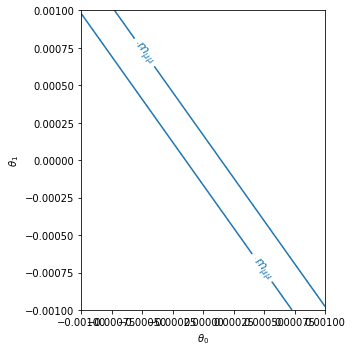

In [12]:
"""
_ = plot_fisher_information_contours_2d(
    [fi_full_mean_proj, fi_rate_mean_proj, fi_dphi_mean_proj],
    [fi_full_cov_proj , fi_rate_cov_proj , fi_dphi_cov_proj ],
    inline_labels=["Full","Rate","$\Delta\phi_{\mu\mu}$"],
    xrange=(-10,10),
    yrange=(-150,150)
)
"""
_ = plot_fisher_information_contours_2d(
    [fi_mll_mean_proj],
    [fi_mll_cov_proj ],
    inline_labels=["$m_{\mu\mu}$"],
    xrange=(-0.001,0.001),
    yrange=(-0.001,0.001)
)

### 5d) Including Systematics

We can also profile over the systematics. The nuisance parameters, by construction, follow Gaussian distributions with mean $\langle \nu \rangle=0 $ and width $\sigma_\nu=1$. This provides an additional contribution to the Fisher Information, $I_{ij}^{}=I_{ij}^{0}+I_{ij}^{\nu}$, where $I_{ij}$ is the total Fisher Info, $I^0_{ij}$ is the Fisher Information obtained by the analyzed process only and $I_{ij}^\nu = \delta_{ik}\delta_{kj}/{\sigma_\nu^2}$ is the addition contribution from the constraints of the nuisance parameter. Let's first calulate the Fisher Info for the nuisance parameter:

In [8]:
fi_nuisance = fisher.calculate_fisher_information_nuisance_constraints()

Now we can add the two Fisher Informations, and also profile over the nuisance parameters

In [13]:
"""
fi_full_mean_prof, fi_full_cov_prof = profile_information(
    fisher_information=fi_full_mean+fi_nuisance, covariance=fi_full_cov,remaining_components=[0,1])
fi_rate_mean_prof, fi_rate_cov_prof = profile_information(
    fisher_information=fi_rate_mean+fi_nuisance, covariance=fi_rate_cov,remaining_components=[0,1])
"""
fi_mll_mean_prof, fi_mll_cov_prof = profile_information(
    fisher_information=fi_mll_mean+fi_nuisance, covariance=fi_mll_cov,remaining_components=[0,1])

Let's now plot the result

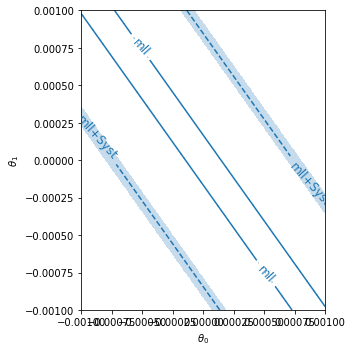

In [14]:
"""
_ = plot_fisher_information_contours_2d(
    [fi_full_mean_proj,fi_full_mean_prof,fi_rate_mean_proj,fi_rate_mean_prof,fi_dphi_mean_proj,fi_dphi_mean_prof],
    [fi_full_cov_proj ,fi_full_cov_prof ,fi_rate_cov_proj ,fi_rate_cov_prof ,fi_dphi_cov_proj ,fi_dphi_cov_prof ],
    inline_labels=["Full","Full+Syst","Rate","Rate+Syst","$\Delta\phi_{\mu\mu}$","$\Delta\phi_{\mu\mu}$+Syst"],
    linestyles=["solid","dashed","solid","dashed","solid","dashed"],
    colors=["C0","C0","C1","C1","C2","C2"],
    xrange=(-10,10),
    yrange=(-150,150),
)
"""

_ = plot_fisher_information_contours_2d(
    [fi_mll_mean_proj,fi_mll_mean_prof],
    [fi_mll_cov_proj ,fi_mll_cov_prof ],
    inline_labels=["mll","mll+Syst"],
    linestyles=["solid","dashed"],
    colors=["C0","C0"],
    xrange=(-0.001,0.001),
    yrange=(-0.001,0.001)
)

### 5e) Comparing different Systematics

We can also compare different systematics separatly, for example scale and PDF uncertainties. To do this, we first project out one and then profile over the other. Let us for simplicity define two functions that do that. 

In [13]:
def profile_and_project_information(
    fi_mean, 
    fi_cov, 
    fi_nuisance, 
    remaining_components_project, 
    remaining_components_profile):
    
    #Project Out Components
    fi_mean_projected,fi_cov_projected = project_information(
        fisher_information=fi_mean, 
        covariance=fi_cov,
        remaining_components=remaining_components_project
    )
    fi_nuisance_projected = project_information(
        fisher_information=fi_nuisance, 
        remaining_components=remaining_components_project,
    )
    
    #Profile over Components
    fi_mean_profiled, fi_cov_profiled = profile_information(
        fisher_information=fi_mean_projected+fi_nuisance_projected, 
        covariance=fi_cov_projected,
        remaining_components=remaining_components_profile,
    )
    
    return fi_mean_profiled, fi_cov_profiled

def get_data_for_plot(fi_mean, fi_cov, fi_nuisance):
    
    #Define Components
    components_plot=[0,1]
    components_scale=components_plot+[2,3]
    components_pdf=components_plot+[i for i in range(4,34)]
    components_all=components_plot+[i for i in range(2,34)]

    #Calculate Fisher Informations
    fi_m_nosyst, fi_c_nosyst = profile_and_project_information(
        fi_mean=fi_mean,fi_cov=fi_cov,fi_nuisance=fi_nuisance,
        remaining_components_project=components_plot,
        remaining_components_profile=components_plot)
    fi_m_scale, fi_c_scale = profile_and_project_information(
        fi_mean=fi_mean,fi_cov=fi_cov,fi_nuisance=fi_nuisance,
        remaining_components_project=components_scale,
        remaining_components_profile=components_plot)
    fi_m_pdf, fi_c_pdf = profile_and_project_information(
        fi_mean=fi_mean,fi_cov=fi_cov,fi_nuisance=fi_nuisance,
        remaining_components_project=components_pdf,
        remaining_components_profile=components_plot)
    fi_m_all, fi_c_all = profile_and_project_information(
        fi_mean=fi_mean,fi_cov=fi_cov,fi_nuisance=fi_nuisance,
        remaining_components_project=components_all,
        remaining_components_profile=components_plot)
    
    return [fi_m_nosyst,fi_m_scale,fi_m_pdf,fi_m_all], [fi_c_nosyst,fi_c_scale,fi_c_pdf,fi_c_all]


Now we can calculate the Fisher Infos cosnidering only scale and only PDF uncertainties

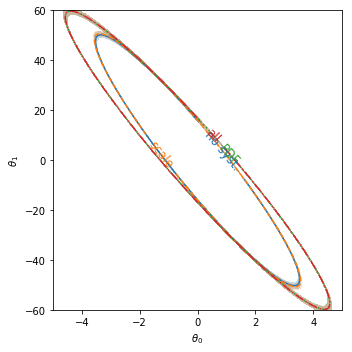

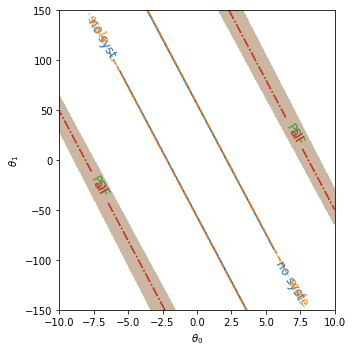

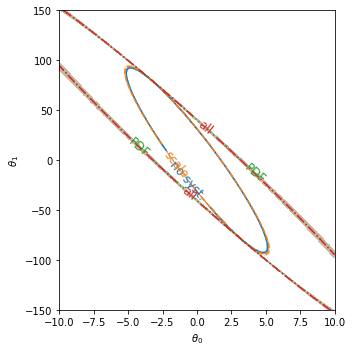

In [14]:
use_labels=["no syst.","scale","PDF","all"]

mean_full, cov_full = get_data_for_plot(fi_full_mean, fi_full_cov, fi_nuisance)
_ = plot_fisher_information_contours_2d(
    mean_full,cov_full,inline_labels=use_labels,xrange=(-5,5),yrange=(-60,60))

mean_rate, cov_rate = get_data_for_plot(fi_rate_mean, fi_rate_cov, fi_nuisance)
_ = plot_fisher_information_contours_2d(
    mean_rate,cov_rate,inline_labels=use_labels,xrange=(-10,10),yrange=(-150,150))

mean_dphi, cov_dphi = get_data_for_plot(fi_dphi_mean, fi_dphi_cov, fi_nuisance)
_ = plot_fisher_information_contours_2d(
    mean_dphi,cov_dphi,inline_labels=use_labels,xrange=(-10,10),yrange=(-150,150))